### Setup, Data Creation, and Function Definitions (Matplotlib Version)

In [54]:
import json
import os
import shutil
from datasets import load_dataset, DatasetDict, Features, Sequence, Value, load_from_disk
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

# --- Configuration ---
JSONL_FILE_NAME = "datasets/ecommerce_ner_re_dataset.jsonl"
SAVE_DIR = "./ner_re_dataset"
SEED = 42
TEST_SIZE = 0.10
VALID_SIZE = 0.1111 # For 80/10/10 split

### Load, Split, and Store Data (using apache arrow format)

This cell performs the main data workflow: loading the JSONL, splitting, and saving to the Apache Arrow format.

In [55]:
# Clean up before running
if os.path.exists(SAVE_DIR): shutil.rmtree(SAVE_DIR)

print("Starting data pipeline...")

# 1. Load JSONL (Allow the library to INFER the schema for stability)
initial_dataset = load_dataset(
    'json', 
    data_files=JSONL_FILE_NAME, 
    split='train',
)

# 1b. CRITICAL: Ensure the nested columns are not JSON strings/Python Objects
# This map function ensures 'entities' and 'relations' are usable lists of dicts.
def parse_nested_columns(example):
    """Parses columns if they were loaded as JSON strings (defensive parsing)."""
    if isinstance(example.get('entities'), str):
        example['entities'] = json.loads(example['entities'])
    if isinstance(example.get('relations'), str):
        example['relations'] = json.loads(example['relations'])
    return example

initial_dataset = initial_dataset.map(parse_nested_columns) 

# 2. Split the dataset (80/10/10 split)
train_valid_splits = initial_dataset.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_valid_dataset = train_valid_splits["train"]
test_dataset = train_valid_splits["test"]

final_splits = train_valid_dataset.train_test_split(test_size=VALID_SIZE, seed=SEED)
train_dataset = final_splits["train"]
valid_dataset = final_splits["test"]

# Create and Store DatasetDict
final_dataset_dict = DatasetDict({"train": train_dataset, "validation": valid_dataset, "test": test_dataset})
final_dataset_dict.save_to_disk(SAVE_DIR)

print(f"DatasetDict saved successfully to: {SAVE_DIR}")

Starting data pipeline...


Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 24523.79 examples/s]

DatasetDict saved successfully to: ./ner_re_dataset


### Define the Label Set

Extract all unique entity types:

In [64]:
entity_labels = set()

# Iterate through train, validation and test datasets
for dataset in final_dataset_dict.values():
    for entity_list in dataset["entities"]:
        for entity in entity_list:
            entity_labels.add(entity["label"])

entity_labels = sorted(list(entity_labels))
label2id = {label: i for i, label in enumerate(entity_labels)}
id2label = {i: label for label, i in label2id.items()}

print(entity_labels)
print(label2id)
print(id2label)

['BRAND', 'CATEGORY', 'COLOR', 'DISCOUNT', 'FEATURE', 'MATERIAL', 'PRICE', 'PRODUCT', 'SHIPPING']
{'BRAND': 0, 'CATEGORY': 1, 'COLOR': 2, 'DISCOUNT': 3, 'FEATURE': 4, 'MATERIAL': 5, 'PRICE': 6, 'PRODUCT': 7, 'SHIPPING': 8}
{0: 'BRAND', 1: 'CATEGORY', 2: 'COLOR', 3: 'DISCOUNT', 4: 'FEATURE', 5: 'MATERIAL', 6: 'PRICE', 7: 'PRODUCT', 8: 'SHIPPING'}


### Dataset visualization

#### Matplotlib Visualization Function


In [56]:
# --- 3. Matplotlib Visualization Function (FINAL ROBUST VERSION) ---
def plot_label_distribution_matplotlib(loaded_splits: DatasetDict, label_type: str):
    """
    Extracts, processes, and plots the distribution of entity or relation labels 
    by iterating directly over the dataset objects.
    """
    key = 'label' if label_type == 'entities' else 'type'
    all_data = []
    
    for split_name, dataset in loaded_splits.items():
        if label_type not in dataset.column_names: continue

        # CRITICAL FIX: Iterate over the dataset directly for maximum stability.
        # This avoids the ambiguity of Arrow-to-Pandas conversion for nested structures.
        for example in dataset:
            items = example.get(label_type)
            # The structure should be a Python list of dictionaries here
            if isinstance(items, list):
                for item in items:
                    # Retrieve label from the dictionary item
                    label_str = item.get(key)
                    if label_str:
                         all_data.append({'Split': split_name, 'Label': label_str, 'Count': 1})
            
    if not all_data:
        # This message will no longer appear on success!
        print(f"No {label_type} found in dataset after processing.")
        return
        
    # Calculate counts and percentages
    plot_df = pd.DataFrame(all_data)
    counts_df = plot_df.groupby(['Split', 'Label'])['Count'].sum().reset_index()
    total_counts = counts_df.groupby('Split')['Count'].sum().reset_index(name='Total')
    plot_df = pd.merge(counts_df, total_counts, on='Split')
    plot_df['Percentage'] = (plot_df['Count'] / plot_df['Total']) * 100
    
    percentage_pivot = plot_df.pivot(index='Split', columns='Label', values='Percentage').fillna(0)
    count_pivot = plot_df.pivot(index='Split', columns='Label', values='Count').fillna(0)
    
    # Ensure splits are in order
    percentage_pivot = percentage_pivot.reindex(["train", "validation", "test"])
    count_pivot = count_pivot.reindex(["train", "validation", "test"])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    percentage_pivot.plot(kind='bar', stacked=True, ax=ax)
    
    # Labeling logic
    cumulative_percentage = np.zeros(len(percentage_pivot))
    for label in percentage_pivot.columns:
        percentages = percentage_pivot[label].values
        for i, (perc, count) in enumerate(zip(percentages, count_pivot[label].values)):
            if perc > 3: 
                ax.text(i, cumulative_percentage[i] + perc / 2, f'{perc:.1f}%', ha='center', va='center', color='black', fontsize=9)
            cumulative_percentage[i] += perc
            
    total_counts_series = count_pivot.sum(axis=1)
    for i, total in enumerate(total_counts_series):
        ax.text(i, 100.5, f'Total: {int(total)}', ha='center', va='bottom', fontsize=10)

    plt.title(f'Distribution of {label_type.capitalize()} Labels per Split (Percentage)', fontsize=14, weight='bold')
    plt.xlabel('Dataset Split', fontsize=12)
    plt.ylabel('Percentage of Examples in Split (%)', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 108)
    plt.legend(title=key.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Dataset Loading and visualization


Generating Entity Distribution Chart...


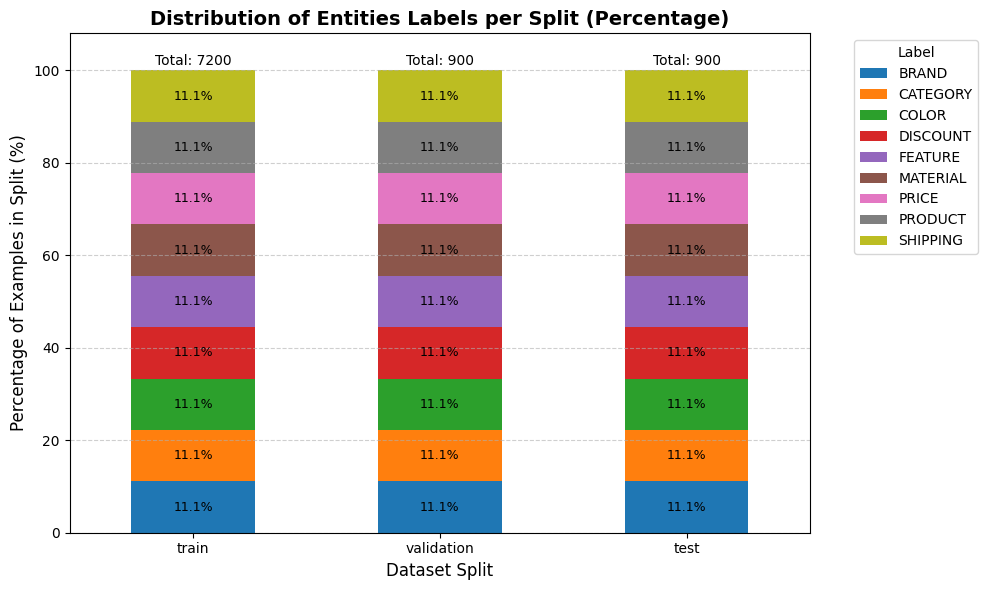


Generating Relation Distribution Chart...


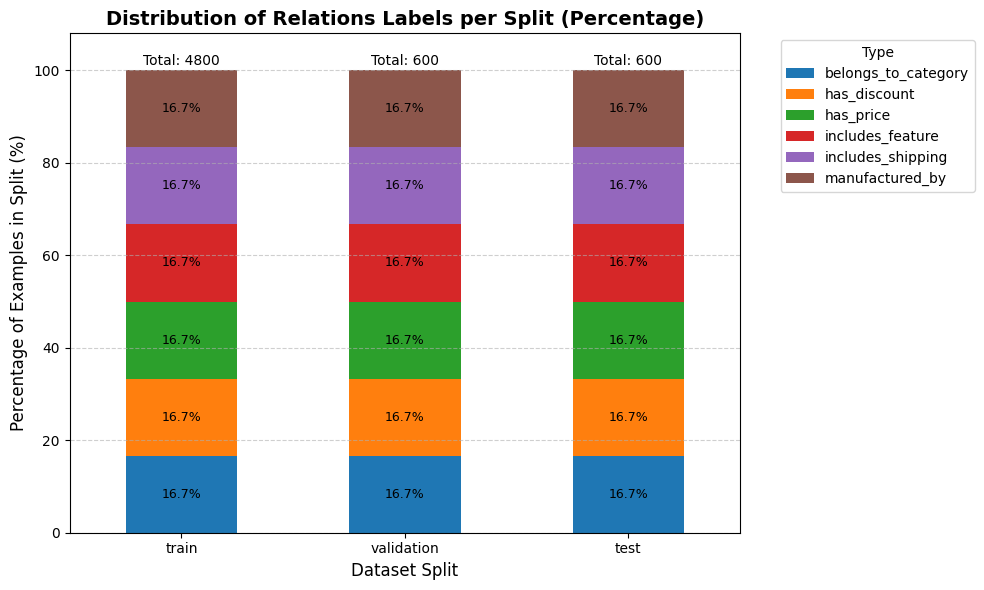


--- Program finished. Charts generated successfully. ---


In [57]:
# 3. Load DatasetDict from disk
loaded_dataset_dict = load_from_disk(SAVE_DIR)

# 4. Visualize Entity Distribution
print("\nGenerating Entity Distribution Chart...")
plot_label_distribution_matplotlib(loaded_dataset_dict, label_type='entities')

# 5. Visualize Relation Distribution
print("\nGenerating Relation Distribution Chart...")
plot_label_distribution_matplotlib(loaded_dataset_dict, label_type='relations')

# Final cleanup
#if os.path.exists(JSONL_FILE_NAME): os.remove(JSONL_FILE_NAME)

print("\n--- Program finished. Charts generated successfully. ---")

In [73]:
def plot_text_length_boxplot(loaded_splits: DatasetDict):
    """
    Calculates text lengths and plots a Matplotlib box plot with median lines.
    """
    length_data = []
    
    for split_name, dataset in loaded_splits.items():
        lengths = [len(example['text']) for example in dataset if 'text' in example]
        for length in lengths:
            length_data.append({'Split': split_name, 'Length': length})
    
    if not length_data:
        print("No text data found for length visualization.")
        return

    length_df = pd.DataFrame(length_data)
    
    order = ["train", "validation", "test"]
    data_to_plot = [length_df[length_df['Split'] == s]['Length'].values for s in order]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create the box plot
    bp = ax.boxplot(data_to_plot, labels=order, vert=True, patch_artist=True)
    
    # Calculate statistics and draw the median line/label
    stats = length_df.groupby('Split')['Length'].agg(['count', 'median']).reindex(order)
    
    for i, split in enumerate(order):
        median = stats.loc[split, 'median']
        count = stats.loc[split, 'count']
        
        # 1. Draw the Median Line (horizontal red dashed line)
        # bp['medians'][i] is the artist for the median line within the box
        # We get the x coordinates from the existing median line (or estimate them)
        x0, x1 = bp['medians'][i].get_xdata()
        ax.hlines(median, x0, x1, color='red', linestyle='--', linewidth=2, zorder=5)

        # 2. Add Median Text Label (to the right of the box)
        # Place the text slightly to the right of the box center
        text_x = i + 1.2
        text_y = median
        ax.text(text_x, text_y, f' Median: {median:.0f}', ha='left', va='center', 
                color='black', weight='bold', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))
        
        # Add Total Count Label
        ax.text(i + 1, ax.get_ylim()[1] * 0.95, f'N={int(count)}', ha='center', va='top', fontsize=10)


    ax.set_title('Text Length Distribution Across Dataset Splits', fontsize=14, weight='bold')
    ax.set_xlabel('Dataset Split', fontsize=12)
    ax.set_ylabel('Text Length (Characters)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


Generating Text Length Box Plot...


/tmp/ipykernel_28797/2432666079.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=order, vert=True, patch_artist=True)


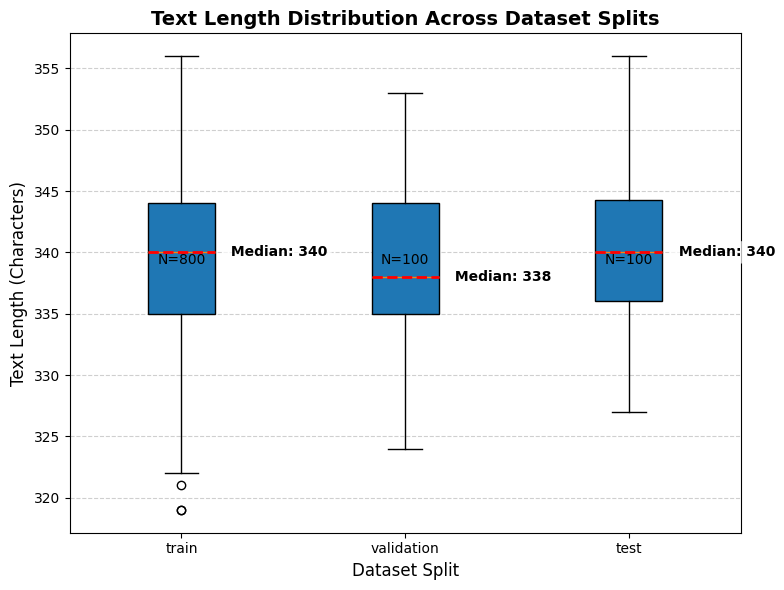

In [74]:
# 4. Visualize Text Length Distribution (NEW STEP)
print("\nGenerating Text Length Box Plot...")
plot_text_length_boxplot(loaded_dataset_dict)